In [1]:
setwd('E:/notebook/miMatch')
library(plyr) 
library(ggplot2)
library(ggpubr)
library(tidyverse)
library(cowplot)


Attaching package: 'ggpubr'


The following object is masked from 'package:plyr':

    mutate


Warning message:
"package 'dplyr' was built under R version 4.3.2"
Warning message:
"package 'stringr' was built under R version 4.3.2"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::desc()      masks plyr::desc()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::id()        masks plyr::id()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::mutate()    masks ggpubr::mutate(), plyr::mutate()
✖ dplyr::rename()    masks plyr::rename()
✖ dplyr::su

# data integration

## meta data

In [3]:
data<-read.csv("Label/fenzu.csv",stringsAsFactors = F,row.names = 1)
IBD<-data[which(data$condition1=="control"&data$condition2=="IBD"),]
rownames(IBD)
path = "E:/notebook/miMatch/Temp"
fileName = dir(path)
fileName = fileName[which(fileName%in%rownames(IBD))]
#----metadata------#
filePath <- sapply(fileName, function(x){ 
  paste(path,x,"Metadata.csv",sep="/")})   
#list meta data
data <- lapply(filePath, function(x){
  read.csv(x, header=T)})  
#list to dataframe
metadata=data[[1]]
for (i in 2:length(data)) {
  metadata<-rbind(metadata,data[[i]])
}
#Remove NA
metadata=metadata[, apply(metadata, 2, function(y) any(!is.na(y)))]
colnames(metadata)
table(metadata$study_condition)

[1] "27"   "36"   "38"   "48_1" "59"

[1] "study_name"                 "sample_id"                 
 [3] "subject_id"                 "body_site"                 
 [5] "antibiotics_current_use"    "study_condition"           
 [7] "disease"                    "age"                       
 [9] "age_category"               "gender"                    
[11] "country"                    "non_westernized"           
[13] "sequencing_platform"        "DNA_extraction_kit"        
[15] "PMID"                       "number_reads"              
[17] "number_bases"               "minimum_read_length"       
[19] "median_read_length"         "NCBI_accession"            
[21] "curator"                    "BMI"                       
[23] "family"                     "days_from_first_collection"
[25] "family_role"                "location"                  
[27] "visit_number"               "disease_subtype"           
[29] "treatment"                  "disease_location"          
[31] "calprotectin"               "HBI"                       
[33] "SCCAI"                      "remission"                 
[35] "mgs_richness"               "ferm_milk_prod_consumer"


control     IBD 
    796    1730 

In [4]:
#------micro--------#
filePath <- sapply(fileName, function(x){ 
  paste(path,x,"Microbiome.csv",sep="/")})   
data <- lapply(filePath, function(x){
  read.csv(x, header=T,row.names = 1)})  
microdata=data[[1]]
for (i in 2:length(data)) {
  microdata<-merge(microdata,data[[i]],all=T)
}
rownames(microdata)=unlist(sapply(data,function(x){rownames(x)})) 

In [5]:
#---------pathway---------#
filePath <- sapply(fileName, function(x){ 
  paste(path,x,"Pathway.csv",sep="/")})   
data <- lapply(filePath, function(x){
  t(read.csv(x,stringsAsFactors = F,row.names = 1,check.names = F))})  
pathway=data[[1]]
pathway<-cbind(path=rownames(pathway),pathway)
for (i in 2:length(data)) {
  tdata=cbind(path=rownames(data[[i]]),data[[i]])
  pathway<-merge(pathway,tdata,by="path")
}
rownames(pathway)=pathway$path
pathway=pathway[,-1]

In [6]:
#------paired label----------#
filePath <- sapply(fileName, function(x){ 
  paste(path,x,"PSMLabel.csv",sep="/")})   
data <- lapply(filePath, function(x){
  read.csv(x,stringsAsFactors = F,row.names = 1)})  
#list转dataframe
PSMlabel=data[[1]]
for (i in 2:length(data)) {
  PSMlabel<-rbind(PSMlabel,data[[i]],by="micro")
}
PSMlabel<-PSMlabel[-which(PSMlabel$Case=="micro"),]
head(PSMlabel)

,Case,Control
,<chr>,<chr>
0,SKST006_6_G102964,SKST007_6_G102995
1,SKST006_6_G102964,SKST010_1_G102968
2,SKST006_6_G102964,SKST041_3_G103028
3,SKST006_7_G102965,SKST037_2_G103023
4,SKST006_7_G102965,p9223_mo6
5,SKST006_7_G102965,p9281_mo5


In [7]:
write.csv(metadata,"./Label/IBD/IBDmetadata.csv",row.names = F)
write.csv(microdata,"./Label/IBD/IBDmicrodata.csv")
write.csv(t(pathway),"./Label/IBD/IBDpathway.csv")
write.csv(PSMlabel,"./Label/IBD/IBDMatchedLabel.csv",row.names = F)

# controls vs. cases

### country Age and BMI  

In [8]:
pairs<-read.csv("./Label/IBD/IBDMatchedLabel.csv")
umeta<-read.csv("./Label/IBD/IBDmetadata.csv",stringsAsFactors = F)
colnames(umeta)

[1] "study_name"                 "sample_id"                 
 [3] "subject_id"                 "body_site"                 
 [5] "antibiotics_current_use"    "study_condition"           
 [7] "disease"                    "age"                       
 [9] "age_category"               "gender"                    
[11] "country"                    "non_westernized"           
[13] "sequencing_platform"        "DNA_extraction_kit"        
[15] "PMID"                       "number_reads"              
[17] "number_bases"               "minimum_read_length"       
[19] "median_read_length"         "NCBI_accession"            
[21] "curator"                    "BMI"                       
[23] "family"                     "days_from_first_collection"
[25] "family_role"                "location"                  
[27] "visit_number"               "disease_subtype"           
[29] "treatment"                  "disease_location"          
[31] "calprotectin"               "HBI"                       
[33] "SCCAI"                      "remission"                 
[35] "mgs_richness"               "ferm_milk_prod_consumer"

In [9]:
umeta<-umeta%>%select(sample_id,study_condition,age,gender,BMI,country)
unmatched_metaplot<-data.frame(sample_id=rep(umeta$sample_id,2),
                               study_condition=rep(umeta$study_condition,2),
                               Group=rep(c("age","BMI"),each=nrow(umeta)),
                               index=c(umeta$age,umeta$BMI))
mmeta<-data.frame(sample_id=c(pairs$Case,pairs$Control))
mmeta$ID<-rep(1:2023,2)
mmeta<-join(mmeta,umeta,match="first")

uc<-table(umeta$country,umeta$study_condition)[,1]/sum(table(umeta$country,umeta$study_condition)[,1])
mc<-table(umeta$country,umeta$study_condition)[,2]/sum(table(umeta$country,umeta$study_condition)[,2])
unCountry<-data.frame(study_condition=rep(c("control","IBD"),each=5),
                      Group=rep(names(uc),2),
                      index=c(uc,mc))
head(unCountry)

Joining by: sample_id



,study_condition,Group,index
,<chr>,<chr>,<dbl>
1,control,CHN,0.00879397
2,control,DNK,0.22613065
3,control,ESP,0.08919598
4,control,GBR,0.04773869
5,control,USA,0.62814070
6,IBD,CHN,0.00000000


Warning message:
"Removed 386 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Removed 386 rows containing non-finite values (`stat_compare_means()`)."
Warning message:
"Removed 814 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Removed 814 rows containing non-finite values (`stat_compare_means()`)."
Warning message:
"Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned."


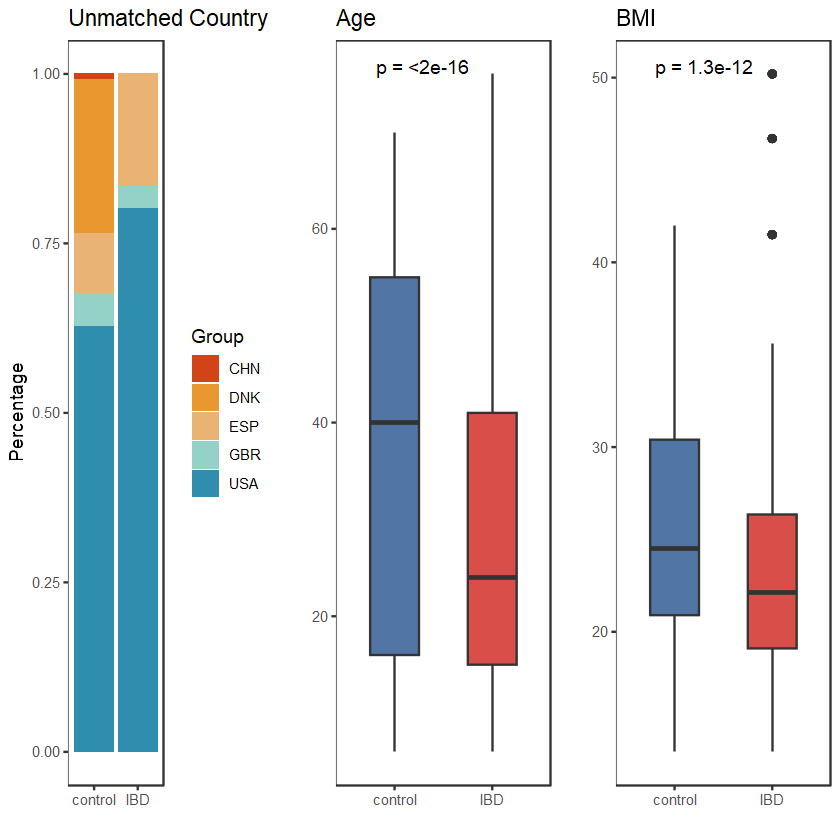

In [10]:
p1<-ggplot(unCountry,aes(study_condition,index,fill=Group))+
  geom_bar(stat="identity",position="stack")+
  ggtitle("Unmatched Country")+
  theme_bw()+
  theme(axis.ticks.length=unit(0.5,'cm'))+
  xlab("")+ylab("Percentage")+
  scale_fill_manual(values = c("#D24317","#E9972F","#E9B374","#94D1C6","#2F8DAE"))+
  theme_bw() + theme(panel.grid=element_blank())

p2=ggplot(umeta, aes(x = study_condition, y = age,fill = study_condition))+
  geom_boxplot(width=0.5) + 
  scale_fill_manual(values = c("#5175A4","#D94E48"))+
  labs(title = "Age",x="",y = "")+
  stat_compare_means(label = "p.format",method = "wilcox.test")+
  theme_bw() + theme(panel.grid=element_blank(),legend.position="none")

p3=ggplot(umeta, aes(x = study_condition, y = BMI,fill = study_condition))+
  geom_boxplot(width=0.5) + 
  scale_fill_manual(values = c("#5175A4","#D94E48"))+
  labs(title = "BMI",x="",y = "")+
  stat_compare_means(label = "p.format",method = "wilcox.test")+
  theme_bw() + theme(panel.grid=element_blank(),legend.position="none")

plot_grid(p1,p2,p3, nrow = 1, align = "v")



In [11]:
uc<-table(mmeta$country,mmeta$study_condition)[,1]/sum(table(mmeta$country,mmeta$study_condition)[,1])
mc<-table(mmeta$country,mmeta$study_condition)[,2]/sum(table(mmeta$country,mmeta$study_condition)[,2])
Country<-data.frame(study_condition=rep(c("control","IBD"),each=5),
                    Group=rep(names(uc),2),
                    index=c(uc,mc))
head(Country)

,study_condition,Group,index
,<chr>,<chr>,<dbl>
1,control,CHN,0.04794859
2,control,DNK,0.04251112
3,control,ESP,0.03657934
4,control,GBR,0.02669303
5,control,USA,0.84626792
6,IBD,CHN,0.00000000


Group.1,x
<chr>,<dbl>
control,30.93103
IBD,28.03678


Group.1,x
<chr>,<dbl>
control,23.48782
IBD,23.25115


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
"Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned."


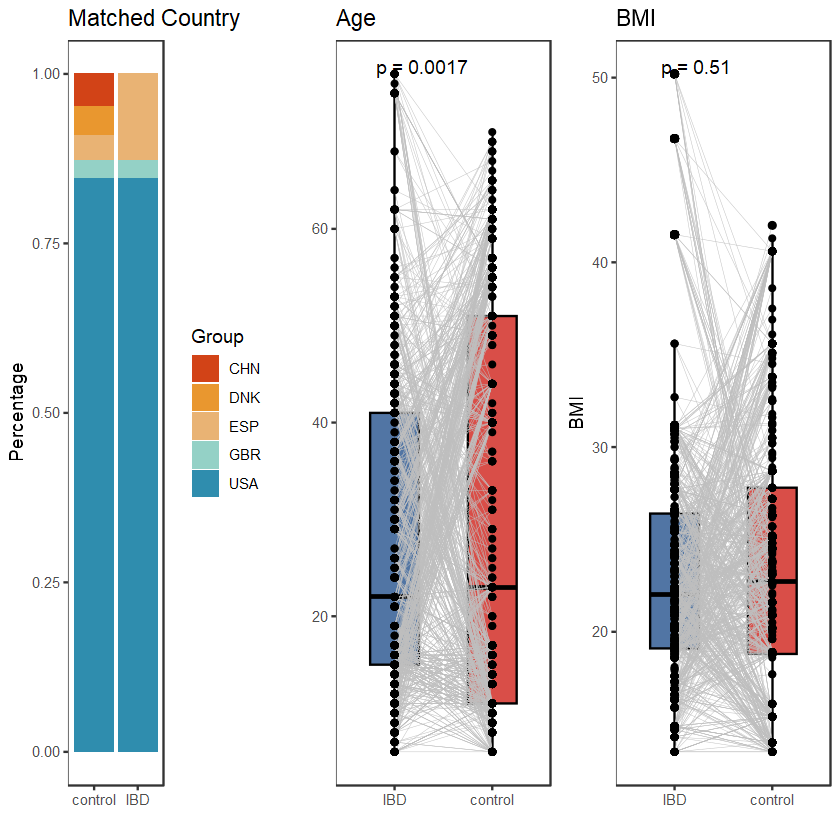

In [12]:
p4<-ggplot(Country,aes(study_condition,index,fill=Group))+
  geom_bar(stat="identity",position="stack")+
  ggtitle("Matched Country")+
  theme_bw()+
  theme(axis.ticks.length=unit(0.5,'cm'))+
  xlab("")+ylab("Percentage")+
  scale_fill_manual(values = c("#D24317","#E9972F","#E9B374","#94D1C6","#2F8DAE"))+
  theme_bw() + theme(panel.grid=element_blank())
remove_id<- mmeta$ID[which(is.na(mmeta$age)|is.na(mmeta$BMI))]
matched_plot<-mmeta[-which(mmeta$ID%in%remove_id),]
aggregate(matched_plot$age,
          by=list(matched_plot$study_condition),
          mean)
aggregate(matched_plot$BMI,
          by=list(matched_plot$study_condition),
          mean)
p5<-ggpaired(matched_plot, x = 'study_condition', y = 'age',id='ID',
             fill = 'study_condition', palette = "jco", 
             line.color = "gray", line.size = 0.1,
             short.panel.labs = FALSE)+
  scale_fill_manual(values = c("#5175A4","#D94E48"))+
  labs(title = "Age",x="",y = "")+
  stat_compare_means(label = "p.format",method = "wilcox.test",paired = T)+
  theme_bw() + theme(panel.grid=element_blank(),legend.position="none")

p6<-ggpaired(matched_plot, x = 'study_condition', y = 'BMI',id='ID',
             fill = 'study_condition', palette = "jco", 
             line.color = "gray", line.size = 0.1,
             short.panel.labs = FALSE)+
  scale_fill_manual(values = c("#5175A4","#D94E48"))+
  labs(title = "BMI",x="",y = "BMI")+
  stat_compare_means(label = "p.format",method = "wilcox.test",paired = T)+
  theme_bw() + theme(panel.grid=element_blank(),legend.position="none")
plot_grid(p4,p5,p6, nrow = 1,align = "v")
IBD<-plot_grid(p1,p2,p3,p4,p5,p6, nrow = 1,align = "v")
pdf("./ShowFigures_Results/Figure 4C_IBD.pdf",height=4,width=16)
IBD
dev.off()